In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv("train.csv")

In [6]:
data.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [7]:
a = data['species'].value_counts()
a

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

In [8]:
whale = data.iloc[:,:][data.species == "killer_whale"]
dolphin = data.iloc[:,:][data.species == "bottlenose_dolphin"]
print(whale)
print(whale.iat[1,0])

                    image       species individual_id
32     0030835e895969.jpg  killer_whale  1816cc1ae38b
46     0044ec4ae5ecfd.jpg  killer_whale  e6388e8a7f58
89     008705d384b02a.jpg  killer_whale  fe8052dcc19e
96     00931cfd50f2b0.jpg  killer_whale  e702dc246ecd
113    00afe60388a560.jpg  killer_whale  1138a9024ee5
...                   ...           ...           ...
50907  ff5d8115749fd6.jpg  killer_whale  9260de22dbe9
50927  ff7aa717a36855.jpg  killer_whale  4d44651c308a
50963  ffa54f1754fbb1.jpg  killer_whale  caee7717cf57
51000  ffcf370369d9d3.jpg  killer_whale  3721912d310c
51002  ffd1f69a8660b3.jpg  killer_whale  a1b8c90ce633

[2455 rows x 3 columns]
0044ec4ae5ecfd.jpg


## Train/Test Set Loading

Flattening the image to 1d-array and load them into train set and test set

In [41]:
train_set, test_set = [], []

for i in range(1, 1501):
    datapoint = np.append(np.asarray(Image.open(f"dataset/train/0-{i}.jpg")).flatten(), 0)
    train_set.append(datapoint)
    
for i in range(1, 1501):
    datapoint = np.append(np.asarray(Image.open(f"dataset/train/1-{i}.jpg")).flatten(), 1)
    train_set.append(datapoint)

train_set = np.stack(train_set)


for i in range(1, 501):
    datapoint = np.append(np.asarray(Image.open(f"dataset/test/0-{i}.jpg")).flatten(), 0)
    test_set.append(datapoint)
    
for i in range(1, 501):
    datapoint = np.append(np.asarray(Image.open(f"dataset/test/1-{i}.jpg")).flatten(), 1)
    test_set.append(datapoint)

test_set = np.stack(test_set)

print(f'train_set shape: {train_set.shape}, test_set shape: {test_set.shape}')

train_set shape: (3000, 49153), test_set shape: (1000, 49153)


In [52]:
train_x, train_y = train_set[:,:-1], train_set[:, -1]
test_x, test_y = test_set[:,:-1], test_set[:, -1]

### PCA Visualization

In [65]:
from sklearn.decomposition import PCA

PCA = PCA(n_components = 2,
         random_state = 0)

vis_x = PCA.fit_transform(train_x)

In [ ]:
import matplotlib.pyplot as plt

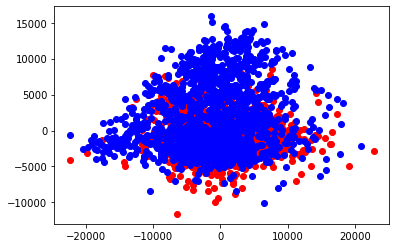

In [70]:
plt.scatter(vis_x[:,0][train_y == 0], vis_x[:,1][train_y == 0], c = 'r')
plt.scatter(vis_x[:,0][train_y == 1], vis_x[:,1][train_y == 1], c = 'b')

### T-SNE Visualization

In [73]:
from sklearn.manifold import TSNE

TSNE = TSNE(n_components = 2,
           verbose = 1,
           random_state = 0)

vis_x2 = TSNE.fit_transform(train_x)

/Users/balechen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/balechen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.096s...
[t-SNE] Computed neighbors for 3000 samples in 11.612s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2250.512142
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.211731
[t-SNE] KL divergence after 1000 iterations: 1.947681


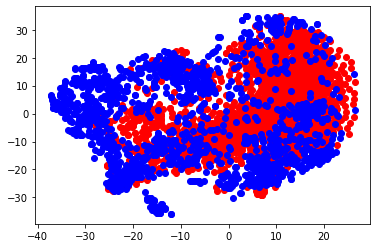

In [74]:
plt.scatter(vis_x2[:,0][train_y == 0], vis_x2[:,1][train_y == 0], c = 'r')
plt.scatter(vis_x2[:,0][train_y == 1], vis_x2[:,1][train_y == 1], c = 'b')

## Model Selection

### KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors = 5,
                          weights = 'uniform',
                           n_jobs = -1)

KNN.fit(train_x, train_y)

KNeighborsClassifier(n_jobs=-1)

In [54]:
pred_y = KNN.predict(test_x)
print(np.mean(pred_y == test_y))

0.809


### Decision Tree

In [75]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(criterion = 'gini',
                          max_depth = None,
                            max_features = None,
                          ccp_alpha = 0.0)

DT.fit(train_x, train_y)

DecisionTreeClassifier()

In [76]:
pred_y = DT.predict(test_x)
print(np.mean(pred_y == test_y))

0.743


### Linear Models

In [59]:
from sklearn import linear_model as LM

In [61]:
LogisticReg = LM.LogisticRegression(penalty = 'l2',
                                   tol = 1e-4,
                                   C = 1.0,
                                   solver = 'saga',
                                   max_iter = 100)

LogisticReg.fit(train_x, train_y)

/Users/balechen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [64]:
pred_y = LogisticReg.predict(test_x)
print(np.mean(pred_y == test_y))

0.827
